In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DataGenerator import ImbalanceGenerator
from sklearn.model_selection import train_test_split
from Hierarchy import EngineTaxonomy
from anytree import RenderTree
import numpy as np
import random
from pathlib import Path
import pandas as pd
import sklearn.metrics as skm
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from pymfe.mfe import MFE

from fairlearn.metrics import count
from sklearn.linear_model import LogisticRegression
from dcm import dcm


### Loading Adult Data

Load Adult Data and extract statistics/Metrics out of it

In [5]:
import openml
# Load ADult
dataset_id = 1590
dataset = openml.datasets.get_dataset(dataset_id)
(X, y, categorical, names) = dataset.get_data(
    target=dataset.default_target_attribute,
    dataset_format="dataframe", 
)
print(categorical)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

X_num = X.select_dtypes(include=numerics)
X_num
X

2022-03-22 13:12:22 INFO openml.datasets.dataset: pickle load data adult


[False, True, False, True, False, True, True, True, True, True, False, False, False, True]


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802.0,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40,United-States
1,38,Private,89814.0,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50,United-States
2,28,Local-gov,336951.0,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40,United-States
3,44,Private,160323.0,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40,United-States
4,18,NaN,103497.0,Some-college,10,Never-married,NaN,Own-child,White,Female,0.0,0.0,30,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302.0,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0.0,0.0,38,United-States
48838,40,Private,154374.0,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,40,United-States
48839,58,Private,151910.0,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0.0,0.0,40,United-States
48840,22,Private,201490.0,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0.0,0.0,20,United-States


In [ ]:
groups = X["sex"]
groups = [int(g == 'Male') for g in groups]
groups_race = [int(g == 'Black') for g in X["race"]]
#print(groups)
print(f"Silhouette: {silhouette_score(X_num,y)}")
print(f"DBI: {davies_bouldin_score(X_num,y)}")
print(f"CHI: {calinski_harabasz_score(X_num,y)}")
print(f"Gini: {ImbalanceGenerator().gini(y)}")
print(f"Gini (sex): {ImbalanceGenerator().gini(groups)}")
print(f"Gini (race): {ImbalanceGenerator().gini(groups_race)}")

### DON'T DO THIS!!!#####
# Takes too much RAM ...
#mfe = MFE(groups=["all"], features=["c1","c2","sil", "f1v", "f2", "n1", "n2", "impconceptvar", "wg_dist"])
#mfe.fit(X_num.to_numpy(), y.to_numpy())
#ft = mfe.extract()
#print(f"{x}: y" for x, y in zip(ft[0], ft[1]))
########

Silhouette: -0.004170237204554553
DBI: 37.04498080341358
CHI: 14.007493479729758
Gini: 0.2607182343065393
Gini (sex): 0.16848204414233647
Gini (race): 0.40407845706564016


 * Warning: It is not possible make equal discretization
 * Warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Getting Statistics from Generated Data

Generate Data and store statistics. Complex statistics are stored using pymfe.

In [11]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from rpy2.robjects.packages import importr

f = 50
n = 1000

gi = 'medium'
ci = 'medium'
c = 20
gs = 0.25

metric_mapping = {'c1': "Class entropy", "c2": "Imbalance Degree", "f1v.mean": "Fishers DR", "f2.mean": "Class Overlap", "vdu": "Dunn Index",
                 "n1": "Border Points", "n2.mean": "Inter/Intra Class Dist", "sil": "SIL", "n3.mean": "NN Error", "ch": "CHI"}

metric_mapping2 = {'c1': "Class entropy", "c2": "Imbalance Degree", "f1": "Fishers DR", "f2": "Class Overlap", "vdu": "Dunn Index",
                 "n1": "Border Points", "n2": "Inter/Intra Class Dist", "sil": "SIL", "n3": "NN Error", "ch": "CHI"}

result_df = pd.DataFrame()

for c in [20]:
    for gs in [0.5]:
        for gi in ['medium']:
            for ci in [ 'medium']:

                print('---------------------------------')
                print(f'---- #classes: {c}, gs={gs}--------')
                generator = ImbalanceGenerator(n_features=f,
                                           n=n,
                                           c=c,
                                           features_remove_percent=0,
                                           hardcoded=False,
                                           group_imbalance=gi,
                                           cls_imbalance=ci,
                                           class_overlap=1.5,
                                           root=EngineTaxonomy().create_taxonomy(),
                                           gs=gs,
                                           n_group_features=10)
                df = generator.generate_data_with_product_hierarchy()
                df = df.dropna(how='all')
                X, y = df[[f"F{i}" for i in range(f)]].to_numpy(), df["target"].to_numpy()
                groups = df["group"].to_numpy()
                print(df.groupby("target").count())
                
                stats = {}
                ##########################################
                # Drop rows where we have only NaN values! --> Happens if we have two classes for only one sample ...
                #not_nan_rows = [id_ for id_, x in enumerate(X.isna().sum(axis=1)) if x == 0]
                #X = X.to_numpy()[not_nan_rows, :]
                #y = y.to_numpy()[not_nan_rows]
                #groups = groups[not_nan_rows].to_numpy()
                #########################################
                complexit_metrics = ["f1", "n1", "n3",]
                #####################################
                ## Complexity metrics  from PyMFE ###
                mfe = MFE(groups=["all"], features=complexit_metrics, 
                          summary=None)
                mfe.fit(X, y)
                ft = mfe.extract()
                for metric, value in zip(ft[0], ft[1]):
                    print(f"{metric_mapping2[metric]} (C): {value}")
                    print(len(value))

                    stats[f"{metric_mapping2[metric]} (C)"] = value
                    
                mfe = MFE(groups=["all"], features=complexit_metrics, 
                          summary="mean")
                mfe.fit(X, y)
                ft = mfe.extract()
                for metric, value in zip(ft[0], ft[1]):
                    print(f"{metric_mapping[metric]} (C): {value}")
                    stats[f"{metric_mapping[metric]} (C)"] = value
                
                for group in groups:
                    group_df = df[df["group"] == group]
                    group_X, group_y = group_df[[f"F{i}" for i in range(f)]].to_numpy(), group_df["target"].to_numpy()
                    mfe = MFE(groups=["all"], features=complexit_metrics, summary=["mean"])
                    mfe.fit(group_X, group_y)
                    ft = mfe.extract()
                    for metric, value in zip(ft[0], ft[1]):
                        print(f"{metric_mapping[metric]} (G): {value}")
                        stats[f"{metric_mapping[metric]} (G)"] = value
                    
                ######################################
                stats_df[f"Gini (C)"] = generator.gini(y)
                stats_df[f"Gini (G)"] = generator.gini(groups)
                
                stats_df = pd.DataFrame({metric_mapping[metric]: [value] for metric, value in stats_dict.items()})

                # Basic stats (#instances etc.)
                stats_df["avg #n groups"] = df.groupby(['group']).size().mean()
                stats_df["avg #n classes+groups"] = df.groupby(['group', 'target']).size().mean()
                stats_df["min #n groups"] = df.groupby(['group']).size().min()
                stats_df["max #n groups"] = df.groupby(['group']).size().max()

                stats_df["target"] = target_name
                stats_df["#c"] = c
                stats_df["gs"] = gs
                stats_df["#n"] = n
                stats_df["gi"] = gi
                stats_df["ci"] = ci

                result_df = pd.concat([result_df, stats_df])

                result_df.to_csv('complexity_metrics.csv', sep=';', decimal=',')

---------------------------------
---- #classes: 20, gs=0.5--------
features that are currently not used: []
Fishers DR (C): [0.49693481 0.19128202 0.54625974 0.30823138 0.24796452 0.47150081
 0.27480669 0.52418864 0.73704637 0.18030102 0.4572813  0.50299508
 0.32517803 0.40370458 0.14816664 0.48894456 0.18334909 0.3997349
 0.42624283 0.24649797 0.28919213 0.27755198 0.71439326 0.36442621
 0.53622108 0.25021176 0.87695603 0.28977969 0.2333602  0.51967104
 0.69032751 0.56521481 0.18234926 0.18678033 0.36620075 0.29967368
 0.52425703 0.26010102 0.53500039 0.32115645 0.24556436 0.26440683
 0.47275933 0.15913737 0.23069425 0.27944702 0.37094192 0.42171399
 0.25620875 0.28562922]
50
Border Points (C): 0.6


TypeError: object of type 'float' has no len()

In [77]:
metric_mapping = {'c1': "Class entropy", "c2": "Imbalance Degree", "f1v.mean": "Fishers DR","f1.mean": "Fishers DR", "f2.mean": "Class Overlap", "vdu": "Dunn Index",
                 "n1": "Border Points", "n2.mean": "Inter/Intra Class Dist", "sil": "SIL", "n3.mean": "NN Error", "ch": "CHI"}

acc_per_ci = {'cls_imbalance': [], 'accuracy': [], 'accuracy Type': []}
ci_mapping = {'very_balanaced': 'Very Balanced'}
c = 20
for ci in ["very_balanced","balanced", "medium", "imbalanced", "very_imbalanced"]:
    print("-----------------------")
    print(ci)
    generator = ImbalanceGenerator(n_features=f,
                               n=n,
                               c=c,
                               features_remove_percent=0,
                               hardcoded=False,
                               group_imbalance=gi,
                               cls_imbalance=ci,
                               class_overlap=1.5,
                               root=EngineTaxonomy().create_taxonomy(),
                               gs=gs,
                               n_group_features=10)
    df = generator.generate_data_with_product_hierarchy()
    X, y = df[[f"F{i}" for i in range(f)]].to_numpy(), df["target"].to_numpy()

    df["counter"] = df.groupby("target")["target"].transform('count')
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import train_test_split
    df_train, df_test = train_test_split(df, train_size=0.7, stratify=df["target"])
    from sklearn.ensemble import RandomForestClassifier

    X_train, y_train = df_train[[f"F{i}" for i in range(50)]], df_train["target"]
    X_test, y_test = df_test[[f"F{i}" for i in range(50)]], df_test["target"]

    model_X = RandomForestClassifier()
    model_X.fit(X_train, y_train)
    y_pred_X = model_X.predict(X_test)
    import sklearn.metrics as skm
    from fairlearn.metrics import MetricFrame
    from sklearn.metrics import accuracy_score
    from fairlearn.metrics import count
    from functools import partial

    mf_X = MetricFrame({'accuracy': skm.accuracy_score, 
                        'F1': partial(skm.f1_score, average='weighted'), 
                        'prec': partial(skm.precision_score, average='weighted'), 
                        'recall': partial(skm.recall_score, average='weighted'),
                                'count': count},
                     y_true=y_test,
                     y_pred=y_pred_X,
                     sensitive_features=df_test['target'])
    print(mf_X.by_group)
    frame = mf_X.by_group
    frame["accuracy"] = (frame["accuracy"] * frame["count"]) / sum(frame["count"])
    acc_per_ci["cls_imbalance"].append(ci)
    acc_per_ci["accuracy"].append(frame["accuracy"].sum())
    acc_per_ci["accuracy Type"].append("All")
    
    # Minority Classes
    acc_per_ci["cls_imbalance"].append(ci)
    min_acc = frame[frame['count'] < frame['count'].median()]['accuracy'].sum()
    acc_per_ci["accuracy"].append(min_acc)
    acc_per_ci["accuracy Type"].append("Minority")
    
    
    # Majority Classes
    maj_acc = frame[frame['count'] >= frame['count'].median()]['accuracy'].sum()
    acc_per_ci["cls_imbalance"].append(ci)
    #min_acc = frame[frame['count'] < frame['count'].median()]['accuracy'].mean()
    acc_per_ci["accuracy"].append(maj_acc)
    acc_per_ci["accuracy Type"].append("Majority")
    
    print(f"minority: {frame[frame['count'] < frame['count'].median()]['accuracy'].sum()}")
    print(f"majority: {frame[frame['count'] >= frame['count'].median()]['accuracy'].sum()}")


-----------------------
very_balanced
features that are currently not used: []


 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no tr

        accuracy        F1 prec    recall count
target                                         
0       0.263158  0.416667  1.0  0.263158    19
1            0.5  0.666667  1.0       0.5    26
2       0.459459   0.62963  1.0  0.459459    37
3       0.680851  0.810127  1.0  0.680851    47
4       0.210526  0.347826  1.0  0.210526    19
5       0.692308  0.818182  1.0  0.692308    26
6       0.166667  0.285714  1.0  0.166667     6
7            0.5  0.666667  1.0       0.5     8
8       0.285714  0.444444  1.0  0.285714     7
9            0.0       0.0  0.0       0.0     2
10           1.0       1.0  1.0       1.0     4
11          0.25       0.4  1.0      0.25     4
12           0.0       0.0  0.0       0.0     2
13      0.333333       0.5  1.0  0.333333     9
14      0.071429  0.133333  1.0  0.071429    14
15      0.823529  0.903226  1.0  0.823529    17
16      0.333333       0.5  1.0  0.333333    12
17           0.4  0.571429  1.0       0.4    15
18      0.416667  0.588235  1.0  0.41666

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true sampl

        accuracy        F1 prec    recall count
target                                         
0       0.541667  0.702703  1.0  0.541667    24
1       0.409091  0.580645  1.0  0.409091    22
2       0.652174  0.789474  1.0  0.652174    46
3            0.5  0.666667  1.0       0.5    38
4       0.272727  0.428571  1.0  0.272727    22
5       0.428571       0.6  1.0  0.428571    21
6       0.666667       0.8  1.0  0.666667     6
7          0.125  0.222222  1.0     0.125     8
8            0.0       0.0  0.0       0.0     6
9            0.5  0.666667  1.0       0.5     4
10      0.666667       0.8  1.0  0.666667     3
11           0.0       0.0  0.0       0.0     3
12      0.333333       0.5  1.0  0.333333     3
13      0.866667  0.928571  1.0  0.866667    15
14      0.357143  0.526316  1.0  0.357143    14
15           0.6      0.75  1.0       0.6    15
16      0.266667  0.421053  1.0  0.266667    15
17      0.333333       0.5  1.0  0.333333    15
18      0.181818  0.307692  1.0  0.18181

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in l

        accuracy        F1 prec    recall count
target                                         
0       0.903226  0.949153  1.0  0.903226    31
1       0.347826  0.516129  1.0  0.347826    23
2       0.843137  0.914894  1.0  0.843137    51
3         0.3125   0.47619  1.0    0.3125    32
4       0.708333  0.829268  1.0  0.708333    24
5       0.277778  0.434783  1.0  0.277778    18
6       0.571429  0.727273  1.0  0.571429     7
7            0.0       0.0  0.0       0.0     5
8            0.0       0.0  0.0       0.0     3
9            1.0       1.0  1.0       1.0     5
10           0.5  0.666667  1.0       0.5     4
11           0.0       0.0  0.0       0.0     2
12           0.8  0.888889  1.0       0.8     5
13           0.7  0.823529  1.0       0.7    20
14      0.588235  0.740741  1.0  0.588235    17
15      0.461538  0.631579  1.0  0.461538    13
16        0.1875  0.315789  1.0    0.1875    16
17           0.0       0.0  0.0       0.0     9
18      0.285714  0.444444  1.0  0.28571

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 i

        accuracy        F1 prec    recall count
target                                         
0       0.984375  0.992126  1.0  0.984375    64
1            0.0       0.0  0.0       0.0     7
2       0.936508  0.967213  1.0  0.936508    63
3            0.0       0.0  0.0       0.0    10
4       0.970588  0.985075  1.0  0.970588    34
5            0.0       0.0  0.0       0.0     5
6            1.0       1.0  1.0       1.0     7
7            0.0       0.0  0.0       0.0     2
8            0.0       0.0  0.0       0.0     1
9            1.0       1.0  1.0       1.0     8
10           0.0       0.0  0.0       0.0     2
11           0.0       0.0  0.0       0.0     1
12           1.0       1.0  1.0       1.0    10
13      0.918919  0.957746  1.0  0.918919    37
14      0.736842  0.848485  1.0  0.736842    19
15           0.0       0.0  0.0       0.0     7
16      0.666667       0.8  1.0  0.666667    15
17           0.0       0.0  0.0       0.0     2
18           0.0       0.0  0.0       0.

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 i

 * Warning: FixedFormatter should only be used together with FixedLocator


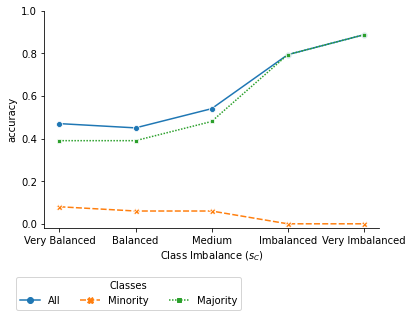

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.lineplot(data=pd.DataFrame(acc_per_ci), x="cls_imbalance", y="accuracy", hue="accuracy Type", style="accuracy Type", markers=True)
plt.legend(bbox_to_anchor=(-0.1, -0.3), ncol=3, loc="center left", title="Classes") 
ax.set_xticklabels(["Very Balanced","Balanced","Medium","Imbalanced", "Very Imbalanced"])
ax.set_xlabel(r"Class Imbalance ($s_C$)")
#ax.set_ylabel("Complexity Measure Value")
ax.set_ylim([-0.02,1.0])
#plt.legend(bbox_to_anchor=(-0.1, -0.3), ncol=7, loc="center left", title="Complexity Measures")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(f"../evaluation/Figures/C1_accuracy_min_maj.pdf", bbox_inches='tight')

In [ ]:
#     df_minority = df[df["counter"] < df["counter"].median()]
#     X_min = df_minority[[f"F{i}" for i in range(f)]].to_numpy()
#     y_min = df_minority["target"].to_numpy()
#     rf.fit(X_min, y_min)
#     print(accuracy_score(y_min, rf.predict(X_min)))
    
#     df_majority = df[df["counter"] >= df["counter"].median()]

#     for frame, name in zip([df_minority, df_majority], ["minority", "majority"]):
#         print("-----------------------")
#         print(f"frame: {name}")
#         X = frame[[f"F{i}" for i in range(f)]].to_numpy()
#         y = frame["target"].to_numpy()
#         mfe = MFE(groups=["all"], features=complexit_metrics, 
#                   summary="mean")
#         mfe.fit(X, y)
#         ft = mfe.extract()
#         for metric, value in zip(ft[0], ft[1]):
#             print(f"{metric_mapping[metric]} (C): {value}")
#             stats[f"{metric_mapping[metric]} (C)"] = value

In [ ]:
mf = MetricFrame({'accuracy': skm.accuracy_score, 
                    'F1': partial(skm.f1_score, average='weighted'), 
                    'prec': partial(skm.precision_score, average='weighted'), 
                    'recall': partial(skm.recall_score, average='weighted'),
                            'count': count},
                 y_true=df_test['target'],
                 y_pred=df_test['predictions'],
                 sensitive_features=df_test['group'])

In [88]:
def extract_mfes(X, y, meta_feature_set, summary=["mean"], groups=["all"]):
    mfe = MFE(groups=["all"], features=meta_feature_set,
              summary=summary)
    mfe.fit(X, y)
    ft = mfe.extract()
    return ft

metric_mapping = {'c1': "Class entropy", "c2": "Imbalance Degree", "f1v.mean": "Fishers DR", "f2.mean": "Class Overlap", "vdu": "Dunn Index",
                 "n1": "Border Points", "n2.mean": "Inter/Intra Class Dist", "sil": "SIL", "n3.mean": "NN Error", "ch": "CHI"}
c = 100
gs = 0
f = 100
n = 1000
gi = 'very_balanced'
ci = 'very_balanced'
generator = ImbalanceGenerator(n_features=f,
                           n_samples_total=n,
                           total_n_classes=c,
                           features_remove_percent=0,
                           hardcoded=False,
                           group_imbalance=gi,
                           cls_imbalance=ci,
                           class_overlap=1.5,
                           root=EngineTaxonomy().create_taxonomy(),
                           group_separation=gs,
                           n_group_features=10)
df = generator.generate_data_with_product_hierarchy()
print(df.shape)
df = df.dropna(how='any')
print(df.shape)
X, y = df[[f"F{i}" for i in range(f)]].to_numpy(), df["target"].to_numpy()
groups = df["group"].unique()



---------------------------------
---- #classes: 100, gs=0--------
features that are currently not used: []
(1000, 107)
(1000, 107)


In [89]:
print('---------------------------------')
print(f'---- #classes: {c}, gs={gs}--------')
stats = {}
##########################################
# Drop rows where we have only NaN values! --> Happens if we have two classes for only one sample ...
#not_nan_rows = [id_ for id_, x in enumerate(X.isna().sum(axis=1)) if x == 0]
#X = X.to_numpy()[not_nan_rows, :]
#y = y.to_numpy()[not_nan_rows]
#groups = groups[not_nan_rows].to_numpy()
#########################################
complexit_metrics = ["f1v", "f2", "n1", "n2", "c1", "c2", "n3",]
CVI_s = ["sil", "ch", "vdu"]
#####################################
## Complexity metrics  from PyMFE ###
ft = extract_mfes(X,y,complexit_metrics)
for metric, value in zip(ft[0], ft[1]):
    print(f"{metric_mapping[metric]} (C): {value}")
    stats[f"{metric_mapping[metric]} (C)"] = value


for group in groups:
    group_df = df[df["group"] == group]
    group_X, group_y = group_df[[f"F{i}" for i in range(f)]].to_numpy(), group_df["target"].to_numpy()
    ft = extract_mfes(group_X,group_y, complexit_metrics)
    for metric, value in zip(ft[0], ft[1]):
        metric_name = f"{metric_mapping[metric]} (G)"
        if metric_name in stats:
            stats[f"{metric_mapping[metric]} (G)"].append(value)
        else:
            stats[f"{metric_mapping[metric]} (G)"] = [value]

for key, value in stats.items():
    if "(G)" in key:
        stats[key] = np.nanmean(value)
        
ft = extract_mfes(X, y, CVI_s)
for metric, value in zip(ft[0], ft[1]):
    print(f"{metric_mapping[metric]}: {value}")
    stats[f"{metric_mapping[metric]}"] = value

print(stats)

---------------------------------
---- #classes: 100, gs=0--------


 * Warning: divide by zero encountered in true_divide


Class entropy (C): 0.9662486989182697
Imbalance Degree (C): 0.003101517527922426
Fishers DR (C): 0.4889595538591901
Class Overlap (C): 1.1347203224354809e-10
Border Points (C): 0.971
Inter/Intra Class Dist (C): 0.5539196892195815
NN Error (C): 0.956


 * Warning: Can't extract feature 'f1v'.
 Exception message: ValueError('expected matrix').
 Will set it as 'np.nan' for all summary functions.
 * Warning: Mean of empty slice.
 * Warning: invalid value encountered in double_scalars
 * Warning: Can't summarize feature 'f1v' with summary 'mean'. Will set it as 'np.nan'.
 * Warning: Can't extract feature 'f1v'.
 Exception message: ValueError('expected matrix').
 Will set it as 'np.nan' for all summary functions.
 * Warning: Mean of empty slice.
 * Warning: invalid value encountered in double_scalars
 * Warning: Can't summarize feature 'f1v' with summary 'mean'. Will set it as 'np.nan'.
 * Warning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


CHI: 1.1896144478301796
SIL: -0.05636389132834306
Dunn Index: 0.0
{'Class entropy (C)': 0.9662486989182697, 'Imbalance Degree (C)': 0.003101517527922426, 'Fishers DR (C)': 0.4889595538591901, 'Class Overlap (C)': 1.1347203224354809e-10, 'Border Points (C)': 0.971, 'Inter/Intra Class Dist (C)': 0.5539196892195815, 'NN Error (C)': 0.956, 'Class entropy (G)': 0.9845745347192153, 'Imbalance Degree (G)': 0.011084872217797954, 'Fishers DR (G)': 0.8266767236588964, 'Class Overlap (G)': 1.0280397974792868e-20, 'Border Points (G)': 0.8683133755940131, 'Inter/Intra Class Dist (G)': 0.5212593117138279, 'NN Error (G)': 0.802475154225389, 'CHI': 1.1896144478301796, 'SIL': -0.05636389132834306, 'Dunn Index': 0.0}


In [3]:


np.random.seed(0)
random.seed(0)
stats = []

for n in [1000, 2000, 5000, 7000, 10000]:
    for f in [20, 50, 80, 100]:
        for c in [10, 30, 50, 70, 100]:
            for gi in ["very_balanced", "balanced", "medium","imbalanced", "very_imbalanced"]:
                for ci in ["very_balanced", "balanced", "medium","imbalanced", "very_imbalanced"]:
                    for gs in [0, 0.5, 1, 3, 5]:
                        generator = ImbalanceGenerator(n_features=f,
                                                       n_samples_total=n,
                                                       total_n_classes=c,
                                                       features_remove_percent=0,
                                                       hardcoded=False,
                                                       group_imbalance=gi,
                                                       cls_imbalance=ci,
                                                       class_overlap=1.5,
                                                       root=EngineTaxonomy().create_taxonomy(),
                                                       group_separation=gs,
                                                       n_group_features=10)

                        dataset_name = f'n{n}_f{f}_c{c}_gi{gi}_ci{ci}_gs{gs}'
                        df = generator.generate_data_with_product_hierarchy()
                        print(RenderTree(generator.root))
                        df_train, df_test = train_test_split(df, train_size=0.7, stratify=df[["group", "target"]])

                        Path("data").mkdir(parents=True, exist_ok=True)
                        Path("stats").mkdir(parents=True, exist_ok=True)
                        Path("predictions").mkdir(parents=True, exist_ok=True)

                        df_train.to_csv(f'data/train_{dataset_name}.csv')
                        df_test.to_csv(f'data/test_{dataset_name}.csv')

                        #### Dataset statistics ####
                        class_gini = generator.gini(df['target'])
                        group_gini = generator.gini(df['group'])
                        avg_n_groups = df.groupby(['group']).size().mean()
                        avg_c_groups = df.groupby(['group', 'target']).size().mean()
                        min_n_groups = df.groupby(['group']).size().min()
                        max_n_groups = df.groupby(['group']).size().max()

                        stats.append({'gini class': class_gini,
                                      'gini group': group_gini, 
                                      'min n groups': min_n_groups,
                                      'max n groups': max_n_groups,
                                      'avg n groups': avg_n_groups, 
                                      'avg c groups': avg_c_groups,
                                     'dataset':dataset_name})
                        pd.DataFrame(stats).to_csv('stats/stats.csv')

                        ### Prediction part ###
                        X_train, y_train = df_train[[f"F{i}" for i in range(f)]], df_train["target"]
                        X_test, y_test = df_test[[f"F{i}" for i in range(f)]], df_test["target"]

                        ## Whole data ##
                        model_X = LogisticRegression()
                        model_X.fit(X_train, y_train)
                        y_pred_X = model_X.predict(X_test)
                        mf_X = MetricFrame({'accuracy':skm.accuracy_score,
                                'count': count}, y_true=y_test, y_pred=y_pred_X, sensitive_features=df_test['group'])
                        mf_X.by_group.to_csv(f'predictions/X_{dataset_name}.csv')

                        ## For each group ##
                        model_repo = {}
                        for group in df_train["group"]:
                            group_df = df_train[df_train["group"] == group]
                            group_X = group_df[[f"F{i}" for i in range(f)]]
                            group_y = group_df["target"]
                            model = LogisticRegression()
                            model.fit(group_X, group_y)
                            model_repo[group] = model
                        df_test["predictions"] = df.apply(lambda row: model_repo[row["group"]].predict(row[[f"F{i}" for i in range(f)]].to_numpy().reshape(1,-1))[0], axis=1)
                        mf = MetricFrame({'accuracy':skm.accuracy_score,
                                'count': count},y_true=df_test['target'],y_pred=df_test['predictions'],
                                         sensitive_features=df_test['group'])
                        mf.by_group.to_csv(f'predictions/group_{dataset_name}.csv')

features that are currently not used: []
Level-0;Engine[n_samples=1000, n_classes=10, classes=(0, 10)]
├── Level-1;Diesel[n_samples=496, n_classes=6, classes=(0, 6)]
│   ├── Level-2;DE-OM1[n_samples=160, n_classes=2, classes=(0, 2)]
│   │   ├── Level-3;DE-OM1-2[n_samples=26, n_classes=2, classes=(0, 2), class_occurences=[12, 14]]
│   │   ├── Level-3;DE-OM1-3[n_samples=27, n_classes=2, classes=(0, 2), class_occurences=[13, 14]]
│   │   ├── Level-3;DE-OM1-4[n_samples=34, n_classes=2, classes=(0, 2), class_occurences=[16, 18]]
│   │   ├── Level-3;DE-OM1-5[n_samples=36, n_classes=2, classes=(0, 2), class_occurences=[17, 19]]
│   │   └── Level-3;DE-OM1-6[n_samples=37, n_classes=2, classes=(0, 2), class_occurences=[17, 20]]
│   ├── Level-2;DE-OM2[n_samples=161, n_classes=3, classes=(2, 5)]
│   │   ├── Level-3;DE-OM2-1[n_samples=30, n_classes=2, classes=(2, 4), class_occurences=[14, 16]]
│   │   ├── Level-3;DE-OM2-2[n_samples=31, n_classes=2, classes=(3, 5), class_occurences=[15, 16]]
│   │  

C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\tschecds\anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "
Found 29 subgroups. Evaluation may be slow
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not h

C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450

C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\tschecds\anaconda3\lib\site-packages\sklearn\base.py:450

SystemExit: 

C:\Users\tschecds\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [45]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, train_size=0.7, stratify=df["group"])

## Run Classifier on whole data and on each group separately

In [51]:
from sklearn.ensemble import RandomForestClassifier

X_train, y_train = df_train[[f"F{i}" for i in range(50)]], df_train["target"]
X_test, y_test = df_test[[f"F{i}" for i in range(50)]], df_test["target"]

model_X = RandomForestClassifier()
model_X.fit(X_train, y_train)
y_pred_X = model_X.predict(X_test)

In [53]:
import sklearn.metrics as skm
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from fairlearn.metrics import count
from functools import partial

mf_X = MetricFrame({'accuracy': skm.accuracy_score, 
                    'F1': partial(skm.f1_score, average='weighted'), 
                    'prec': partial(skm.precision_score, average='weighted'), 
                    'recall': partial(skm.recall_score, average='weighted'),
                            'count': count},
                 y_true=y_test,
                 y_pred=y_pred_X,
                 sensitive_features=df_test['target'])

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 i

In [56]:
mf_X.by_group

,accuracy,F1,prec,recall,count
target,,,,,
0,0.971429,0.985507,1.0,0.971429,70
1,0.0,0.0,0.0,0.0,4
2,0.921875,0.95935,1.0,0.921875,64
3,0.0,0.0,0.0,0.0,6
4,0.972222,0.985915,1.0,0.972222,36
5,0.0,0.0,0.0,0.0,3
6,0.875,0.933333,1.0,0.875,8
7,0.0,0.0,0.0,0.0,3
8,0.0,0.0,0.0,0.0,1


In [62]:
y_pred_X = model_X.predict(X_test)

In [63]:
accuracy_score(y_pred_X, y_test)

0.11

In [58]:
model_X = LogisticRegression()
model_X.fit(X_train, y_train)
y_pred_X = model_X.predict(X_test)
accuracy_score(y_pred_X, y_test)

 * Warning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.13333333333333333

In [33]:
import pandas as pd
pd.DataFrame({'y_true': y_test, 'y_pred': y_pred_X, 'group': df_test['group']})

,y_true,y_pred,group
249,35,12,DE-OM3-3
611,13,47,GE-OM3-6
433,45,33,GE-OM1-6
770,67,12,GE-OM3-11
852,88,75,GE-OM3-12
...,...,...,...
535,33,23,GE-OM1-7
151,25,12,DE-OM2-6
987,91,47,GE-OM3-13
256,12,12,DE-OM3-3


In [34]:
import sklearn.metrics as skm
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from fairlearn.metrics import count
from functools import partial

mf_X = MetricFrame({'accuracy': skm.accuracy_score, 
                    'F1': partial(skm.f1_score, average='weighted'), 
                    'prec': partial(skm.precision_score, average='weighted'), 
                    'recall': partial(skm.recall_score, average='weighted'),
                            'count': count},
                 y_true=y_test,
                 y_pred=y_pred_X,
                 sensitive_features=df_test['group'])


 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
2022-03-24 10:34:09 WARNING fairlearn.metrics._metric_frame: Found 29 subgroups. Evaluation may be slow
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [35]:
mf_X.by_group

,accuracy,F1,prec,recall,count
group,,,,,
DE-OM1-2,0.0,0.0,0.0,0.0,1
DE-OM1-3,0.0,0.0,0.0,0.0,2
DE-OM1-4,0.0,0.0,0.0,0.0,2
DE-OM1-5,0.0,0.0,0.0,0.0,5
DE-OM1-6,0.0,0.0,0.0,0.0,8
DE-OM2-1,0.0,0.0,0.0,0.0,3
DE-OM2-2,0.0,0.0,0.0,0.0,4
DE-OM2-3,0.0,0.0,0.0,0.0,4
DE-OM2-5,0.0,0.0,0.0,0.0,7


In [92]:
train_test_split(df, train_size=0.7, stratify=df[["group"]])
model_repo = {}
for group in df_train["group"].unique():
    group_df = df_train[df_train["group"] == group]
    group_X = group_df[[f"F{i}" for i in range(100)]].to_numpy()
    group_y = group_df["target"].to_numpy()
    model = RandomForestClassifier()
    model.fit(group_X, group_y)
    model_repo[group] = model

In [83]:
#df_test["predictions"] =
y_group_pred = df_test.apply(lambda row: model_repo[row["group"]].predict(row[[f"F{i}" for i in range(100)]].to_numpy().reshape(1,-1))[0], axis=1).to_numpy()

In [84]:
print(len(y_group_pred))

300


In [85]:
print(accuracy_score(y_group_pred, df_test["target"]))

0.37


In [71]:
mf = MetricFrame({'accuracy': skm.accuracy_score, 
                    'F1': partial(skm.f1_score, average='weighted'), 
                    'prec': partial(skm.precision_score, average='weighted'), 
                    'recall': partial(skm.recall_score, average='weighted'),
                            'count': count},
                 y_true=df_test['target'],
                 y_pred=df_test['predictions'],
                 sensitive_features=df_test['group'])
mf.by_group

 * Warning: You have provided 'metrics' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
2022-03-24 10:48:33 WARNING fairlearn.metrics._metric_frame: Found 29 subgroups. Evaluation may be slow
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 * Warning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

,accuracy,F1,prec,recall,count
group,,,,,
DE-OM1-2,0.0,0.0,0.0,0.0,1
DE-OM1-3,1.0,1.0,1.0,1.0,2
DE-OM1-4,0.5,0.333333,0.25,0.5,2
DE-OM1-5,0.6,0.45,0.36,0.6,5
DE-OM1-6,0.5,0.333333,0.25,0.5,8
DE-OM2-1,1.0,1.0,1.0,1.0,3
DE-OM2-2,0.5,0.5,0.5,0.5,4
DE-OM2-3,0.0,0.0,0.0,0.0,4
DE-OM2-5,0.0,0.0,0.0,0.0,7


In [75]:
mf_g = mf.by_group
mf_g["Model"] = "G"
mf_x = mf_X.by_group
mf_x["Model"] = "X"
pd.concat([mf.by_group, mf_X.by_group])

,accuracy,F1,prec,recall,count,Model
group,,,,,,
DE-OM1-2,0.0,0.0,0.0,0.0,1,G
DE-OM1-3,1.0,1.0,1.0,1.0,2,G
DE-OM1-4,0.5,0.333333,0.25,0.5,2,G
DE-OM1-5,0.6,0.45,0.36,0.6,5,G
DE-OM1-6,0.5,0.333333,0.25,0.5,8,G
DE-OM2-1,1.0,1.0,1.0,1.0,3,G
DE-OM2-2,0.5,0.5,0.5,0.5,4,G
DE-OM2-3,0.0,0.0,0.0,0.0,4,G
DE-OM2-5,0.0,0.0,0.0,0.0,7,G


In [73]:
new_df = mf.by_group.copy()
new_df["accuracy"] = mf.by_group["accuracy"] - mf_X.by_group["accuracy"]
new_df

,accuracy,count
group,,
1,-1.0,1
10,0.142857,7
11,0.4,10
12,0.09375,32
13,0.0,1
14,1.0,2
15,0.6,5
16,-0.133333,15
17,0.6,5


### Run R Library (ECoL) 

In [15]:
c = 20
gs = 0
f = 50
n = 1000
gi = 'medium'
ci = 'medium'
generator = ImbalanceGenerator(n_features=f,
                           n=n,
                           c=c,
                           features_remove_percent=0,
                           hardcoded=False,
                           group_imbalance=gi,
                           cls_imbalance=ci,
                           class_overlap=1.5,
                           root=EngineTaxonomy().create_taxonomy(),
                           gs=gs,
                           n_group_features=10)
df = generator.generate_data_with_product_hierarchy()

features that are currently not used: []


In [16]:
#df.to_csv("test.csv", inde)

In [18]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

ECoL = importr('ECoL')
rpy2_df = robjects.r('''
data = read.csv("test.csv");
complex_ = complexity(data[2:51], factor(data$target));
data.frame(as.list(complex_))
''')
import rpy2.robjects as ro

pd_dt = ro.conversion.rpy2py(rpy2_df)
pd_dt

overlapping.F1.mean,overlapping.F1.sd,overlapping.F1v.mean,...,network.ClsCoef,network.Hubs.mean,network.Hubs.sd
0.958340,0.020884,0.081297,...,0.579180,0.923723,0.181625


In [19]:
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter
with localconverter(ro.default_converter + pandas2ri.converter):
  pd_from_r_df = ro.conversion.rpy2py(rpy2_df)
pd_from_r_df

,overlapping.F1.mean,overlapping.F1.sd,overlapping.F1v.mean,overlapping.F1v.sd,overlapping.F2.mean,overlapping.F2.sd,overlapping.F3.mean,overlapping.F3.sd,overlapping.F4.mean,overlapping.F4.sd,...,linearity.L3.sd,dimensionality.T2,dimensionality.T3,dimensionality.T4,balance.C1,balance.C2,network.Density,network.ClsCoef,network.Hubs.mean,network.Hubs.sd
1,0.95834,0.020884,0.081297,0.07338,0.060903,0.207843,0.672028,0.193688,0.035155,0.158907,...,0.040067,0.05,0.001,0.02,0.897766,0.037984,0.978016,0.57918,0.923723,0.181625


In [20]:
pd_from_r_df.T

,1
overlapping.F1.mean,0.958340
overlapping.F1.sd,0.020884
overlapping.F1v.mean,0.081297
overlapping.F1v.sd,0.073380
overlapping.F2.mean,0.060903
overlapping.F2.sd,0.207843
overlapping.F3.mean,0.672028
overlapping.F3.sd,0.193688
overlapping.F4.mean,0.035155
overlapping.F4.sd,0.158907


In [9]:
pd_from_r_df.T

,1
overlapping.F1.mean,0.361129
overlapping.F1.sd,0.272835
overlapping.F1v.mean,0.029457
overlapping.F1v.sd,0.065424
overlapping.F2.mean,0.000023
overlapping.F2.sd,0.000157
overlapping.F3.mean,0.168758
overlapping.F3.sd,0.274824
overlapping.F4.mean,0.001307
overlapping.F4.sd,0.008769
